Using cached StanModel


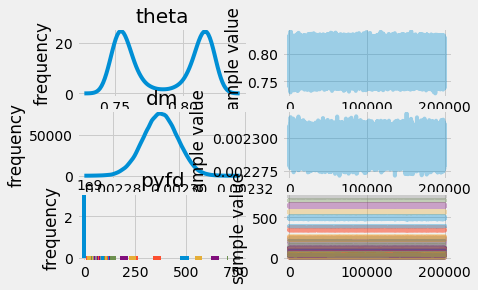

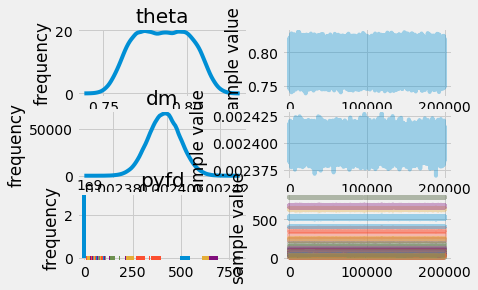

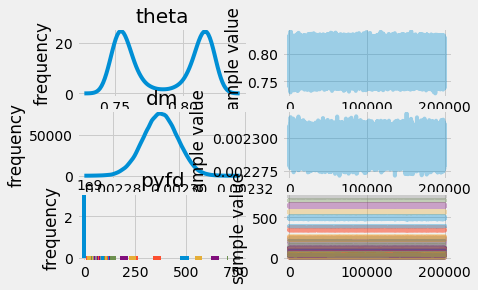

In [5]:
%matplotlib inline

import pystan
import pystan_tools as pst
import smearing_tools as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from math import *
mpl.style.use('fivethirtyeight')


nu_code = """
functions {
    real OscProb(real L, real Elo, real Eup, real theta, real dm){
        real Ec=(Eup+Elo)/2;
        return 1-pow(sin(2*theta),2)*pow(sin(1.27*dm*L/Ec),2);
    }
}

data {
    real L; //baseline [km]
    int<lower=0> Nbins;
    real Ebins[Nbins+1]; //Energy bin boundaries [GeV]
    vector[Nbins] ynd; //number of events measured at ND
    real ttheta; //true value of theta
    real tdm; //true value of dm^2
    matrix[Nbins,Nbins] Sa; //true to reco energy smearing
    matrix[Nbins,Nbins] Sb; //true to reco energy smearing
}

transformed data {
    int y[Nbins]; //number of events measured at FD
    vector[Nbins] ty; //vector version to be converted to int at the end
    real gqoscprobs[Nbins];
    
    //apply oscillation to true spectrum
    for (j in 1:Nbins){
        ty[j]=OscProb(L,Ebins[j],Ebins[j+1],ttheta,tdm) * ynd[j]; 
    }
    
    //apply smearing
    print(ty);
    ty=Sa*ty;
    print(ty);

    //convert vector to int array
    for (j in 1:Nbins){
        int i=0;
        while (i<ty[j]) i=i+1; 
        y[j] = i;
    }

    for (j in 1:Nbins){
        gqoscprobs[j]=OscProb(L,Ebins[j],Ebins[j+1],ttheta,tdm);
    }
}

parameters {
    real<lower=0,upper=1.57> theta;
    real<lower=2e-3,upper=4e-3> dm;
}

transformed parameters {
    vector[Nbins] pyfd; //predicted flux at FD
    for (j in 1:Nbins)
        pyfd[j] = OscProb(L,Ebins[j],Ebins[j+1],theta,dm) * ynd[j];
        
    pyfd=Sb*pyfd;
}

model {
    y ~ poisson(pyfd);
}
"""


#Ebins=[0.5,1.5,2.5,3.5,4.5]
#ynd=[500,500,500,500]
#smearingA=st.smearingA(Ebins,0.05)
#smearingB=st.smearingB(Ebins,0.05,0.2)
#smearingB=st.smearingA(Ebins,0.05)
#nu_dat = {'L':1300, 'Nbins':4, 
#          'Ebins':Ebins,
#          'ynd':ynd,
#          'ttheta':0.7854, 'tdm':2.4e-3, 'Sa':smearingA.tolist(), 'Sb':smearingB.tolist()}

Ebins=[0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1,1.125,1.25,1.375,1.5,1.625,1.75,1.875,2,2.125,2.25,2.375,2.5,2.625,2.75,2.875,3,3.125,3.25,3.375,3.5,3.625,3.75,3.875,4,4.125,4.25,4.375,4.5,4.625,4.75,4.875,5,5.125,5.25,5.375,5.5,5.625,5.75,5.875,6,6.125,6.25,6.375,6.5,6.625,6.75,6.875,7,7.125,7.25,7.375,7.5,7.625,7.75,7.875,8,9,10,12,14,16,18,20]
ynd=[1e-9,0.0186176,0.0865335,0.735213,156.83,401.622,425.576,547.128,671.816,737.864,831.819,859.423,888.056,911.318,940.432,958.79,963.343,985.975,974.608,995.774,979.917,941.153,907.552,865.736,797.247,729.36,659.869,582.71,519.115,455.485,401.686,351.107,297.258,258.408,220.897,188.965,167.309,143.047,122.778,109.995,100.715,89.8686,80.9079,71.9916,65.7639,62.5326,55.6679,52.9838,48.7261,46.6036,43.136,42.8935,41.0557,38.3422,37.0935,36.9174,36.254,35.7731,34.8589,34.7187,33.8421,34.8576,33.4684,33.24,256.508,241.86,447.796,374.344,289.229,210.5,161.397]
smearingA=st.smearingA(Ebins,0.05)
smearingB=st.smearingB(Ebins,0.05,0.05)
#smearingB=st.smearingA(Ebins,0.05)

nu_datAA = {'L':1300, 'Nbins':71, 
          'Ebins':Ebins,
          'ynd':ynd,
          'ttheta':0.7854, 'tdm':2.4e-3, 'Sa':smearingB.tolist(), 'Sb':smearingB.tolist()}

nu_datAB = {'L':1300, 'Nbins':71, 
          'Ebins':Ebins,
          'ynd':ynd,
          'ttheta':0.7854, 'tdm':2.4e-3, 'Sa':smearingB.tolist(), 'Sb':smearingA.tolist()}

sm= pst.StanModel_cache(model_code=nu_code)
fitA = sm.sampling(data=nu_datAA, iter=100000, chains=4)
fitA.plot()
fitB = sm.sampling(data=nu_datAB, iter=100000, chains=4)
fitB.plot()

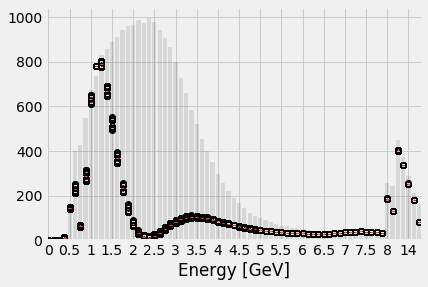

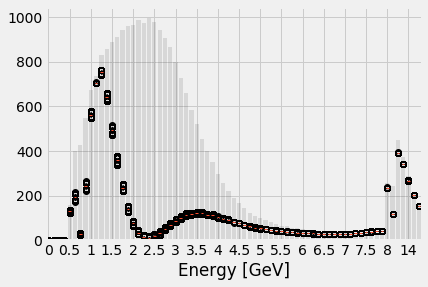

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=1)
plt.bar(np.arange(len(ynd)),ynd, color='black', alpha=0.1)
positions=[i for i in range(len(ynd))]
axes.boxplot(fitA['pyfd'], positions=positions)
plt.setp(axes, xticks=range(len(ynd))[0::4], xticklabels=Ebins[0::4])
plt.xlabel('Energy [GeV]')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1)
plt.bar(np.arange(len(ynd)),ynd, color='black', alpha=0.1)
positions=[i for i in range(len(ynd))]
axes.boxplot(fitB['pyfd'], positions=positions)
plt.setp(axes, xticks=range(len(ynd))[0::4], xticklabels=Ebins[0::4])
plt.xlabel('Energy [GeV]')
plt.show()

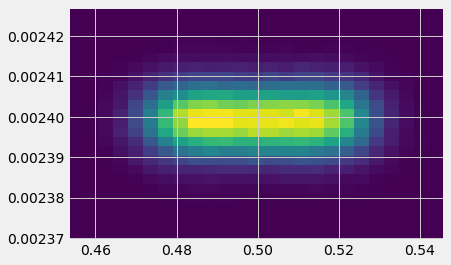

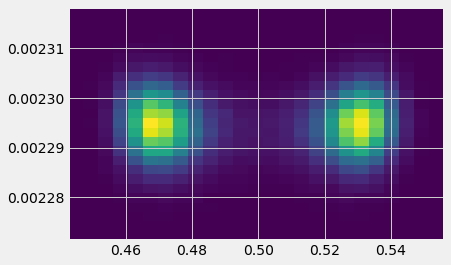

In [7]:
countsA,ybinsA,xbinsA,imageA=plt.hist2d([pow(sin(t),2) for t in fitA['theta']],fitA['dm'], bins=25, normed=True)
plt.show()
countsB,ybinsB,xbinsB,imageB=plt.hist2d([pow(sin(t),2) for t in fitB['theta']],fitB['dm'], bins=25, normed=True)
plt.show()



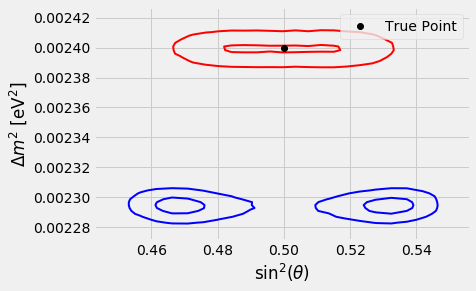

In [8]:
plt.ylabel('$\Delta m^2$ [eV$^2$]')
plt.xlabel('sin$^2$($\\theta$)')
levels=(1,6)
counts_normA=countsA/float(fitA['theta'].shape[0])
plt.contour(counts_normA.transpose(),extent=[ybinsA.min(),ybinsA.max(),xbinsA.min(),xbinsA.max()],linewidths=2, colors=('r', 'r'), levels=levels)
counts_normB=countsB/float(fitB['theta'].shape[0])
plt.contour(counts_normB.transpose(),extent=[ybinsB.min(),ybinsB.max(),xbinsB.min(),xbinsB.max()],linewidths=2, colors=('b', 'b'), levels=levels)

#Add true point
plt.plot(0.5,2.4e-3,'ro', color='black', label='True Point') 


plt.legend()
plt.show()

8901.180385650716 8901.180397950713


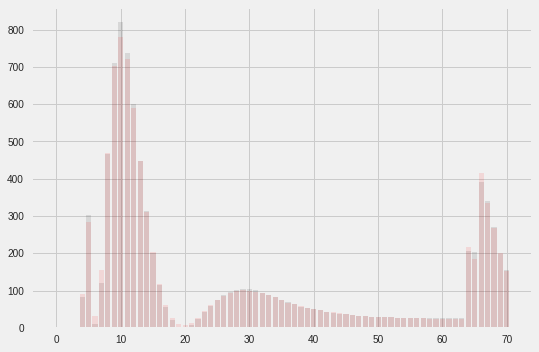

In [5]:
a=[7.1193e-10,0.00795545,0.0854272,0.640129,82.2271,302.571,11.4005,119.293,465.276,710.114,819.374,738.122,600.233,448.273,313.367,200.004,113.497,55.9774,19.7047,2.98776,0.587784,8.72173,23.5937,41.9313,59.603,75.5559,88.3453,96.0625,101.712,103.258,103.175,100.484,93.51,88.3531,81.3251,74.3181,69.8195,62.9735,56.7331,53.1155,50.6296,46.8714,43.6493,40.0676,37.6694,36.7847,33.5651,32.6885,30.7113,29.9655,28.258,28.5941,27.8209,26.3848,25.8975,26.1281,25.9904,25.9587,25.587,25.7621,25.3712,26.3885,25.5724,25.6222,204.689,202.168,392.161,340.63,269.512,199.27,154.479]
b=[7.1193e-10,0.00795545,0.0868825,1.73975,89.9656,283.06,31.5835,154.522,469.295,702.737,780.371,721.112,589.012,447.83,311.422,203.248,118.758,61.2144,26.7848,9.51869,6.85952,13.8205,27.3158,44.0821,60.8417,74.2572,84.3635,94.3031,99.8803,101.647,100.016,95.205,93.3023,86.8648,81.7367,74.5767,67.031,63.5158,59.1344,53.4839,50.3794,46.8039,42.9889,41.4014,38.6037,35.8173,34.5111,32.6892,31.3311,30.2722,29.3145,28.3725,28.0798,27.392,26.3648,26.5469,25.8984,25.2492,24.857,24.7117,23.8136,23.1426,24.0301,23.8422,215.884,183.704,414.734,334.143,268.378,201.122,152.296]
plt.bar(np.arange(len(a)),a, color='black', alpha=0.1)
plt.bar(np.arange(len(b)),b, color='red', alpha=0.1)
print(sum(a), sum(b))